# Character-Level Tokenization and Embeddings

This notebook demonstrates character-level tokenization and embeddings using the Shakespeare dataset.

In [1]:
import torch
import numpy as np
from pathlib import Path

## Load and Inspect the Data

In [2]:
# Read the Shakespeare text
with open('../data/shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Length of dataset in characters: {len(text)}')
print('\nFirst 1000 characters:\n')
print(text[:1000])

Length of dataset in characters: 1115394

First 1000 characters:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods k

## Character-Level Tokenization

In character-level tokenization, each unique character in the text becomes a token. This is the simplest form of tokenization.

In [3]:
# Get all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f'Vocabulary size (unique characters): {vocab_size}')
print('\nAll characters:', ''.join(chars))

Vocabulary size (unique characters): 65

All characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
# Create mappings from characters to integers and back
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Example: encode and decode some text
example_text = "Hello, World!"
encoded = [char_to_idx[ch] for ch in example_text]
decoded = ''.join([idx_to_char[idx] for idx in encoded])

print(f'Original text: {example_text}')
print(f'Encoded: {encoded}')
print(f'Decoded: {decoded}')

Original text: Hello, World!
Encoded: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded: Hello, World!


## Character Embeddings

Now we'll create character embeddings. Each character will be represented by a vector in a higher-dimensional space.

In [5]:
# Parameters for embeddings
embedding_dim = 8  # Dimension of the embedding space

# Create a random embedding table
embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

# Example: get embeddings for a sequence of characters
example_sequence = torch.tensor(encoded)  # Using the encoded text from above
embedded_sequence = embeddings(example_sequence)

print(f'Shape of embedded sequence: {embedded_sequence.shape}')
print('\nEmbedding for first character:')
print(embedded_sequence[0].detach().numpy())

Shape of embedded sequence: torch.Size([13, 8])

Embedding for first character:
[ 2.413681   -1.3746495   0.7716305  -0.71540767 -1.0059905  -1.7517415
 -1.4515655  -0.35231027]


## Visualizing Embeddings

We can visualize the learned embeddings by projecting them to 2D using PCA.

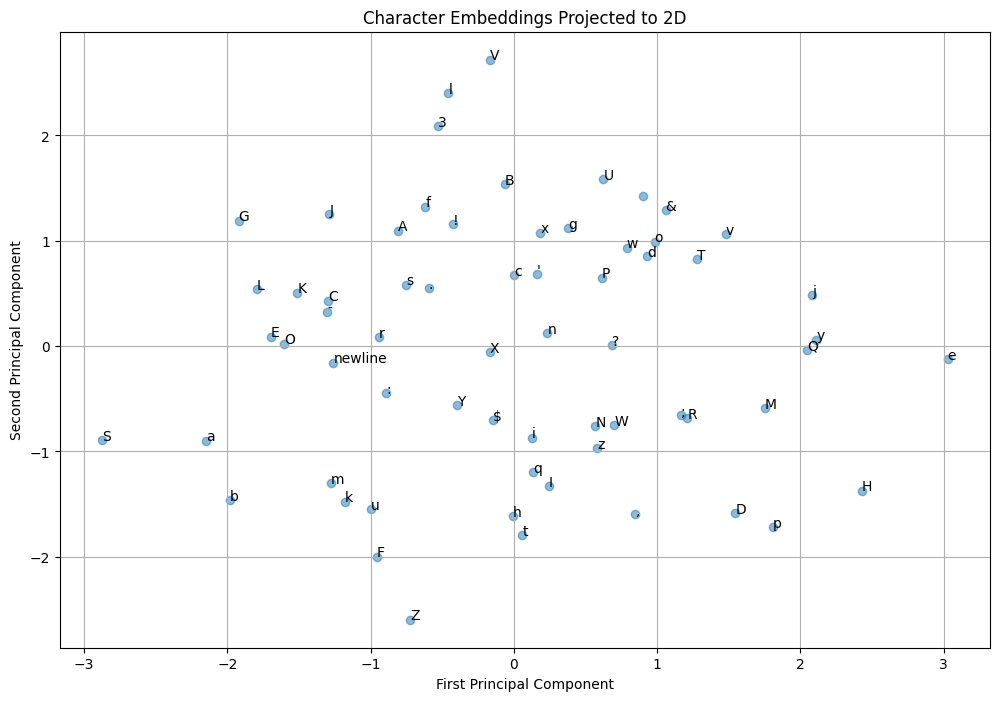

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the embedding weights
weights = embeddings.weight.detach().numpy()

# Project to 2D using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(weights)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (projected[i, 0], projected[i, 1]))

plt.title('Character Embeddings Projected to 2D')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

# Train Embedding function

In [7]:
# Example of how we create training pairs
def show_data_preparation_example():
    # Take a small sample of text
    sample_text = "Hello, World!"
    print(f"Sample text: {sample_text}")
    
    # Convert to indices
    indices = [char_to_idx[ch] for ch in sample_text]
    context_size = 2
    
    print("\nCreating context windows (context_size=2):")
    print("Center char | Context chars (2 before, 2 after)")
    print("-" * 45)
    
    # Show some examples
    for i in range(context_size, len(indices) - context_size):
        center_char = sample_text[i]
        context_chars = (
            sample_text[i-context_size:i] + '*' +
            sample_text[i+1:i+context_size+1]
        )
        
        print(f"    {center_char}     | {context_chars}")
        
    print("\nThese will be converted to tensor indices for training.")
    
# Run the example
show_data_preparation_example()

Sample text: Hello, World!

Creating context windows (context_size=2):
Center char | Context chars (2 before, 2 after)
---------------------------------------------
    l     | He*lo
    l     | el*o,
    o     | ll*, 
    ,     | lo* W
          | o,*Wo
    W     | , *or
    o     |  W*rl
    r     | Wo*ld
    l     | or*d!

These will be converted to tensor indices for training.


In [8]:
# Convert text to indices tensor
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

print(f"Shape of data tensor: {data.shape}")
print(f"First 20 characters as indices: {data[:20]}")
print(f"As characters: {''.join([idx_to_char[idx.item()] for idx in data[:20]])}")

Shape of data tensor: torch.Size([1115394])
First 20 characters as indices: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56])
As characters: First Citizen:
Befor


In [9]:
# Model parameters
embedding_dim = 16
context_size = 2
batch_size = 512
learning_rate = 0.001

In [10]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SkipgramDataset(Dataset):
    def __init__(self, data, context_size):
        self.data = data
        self.context_size = context_size
        self.pairs = []
        
        # Create training pairs
        for i in range(context_size, len(data) - context_size):
            center = data[i]
            context = torch.cat([
                data[i-context_size:i],
                data[i+1:i+context_size+1]
            ])
            self.pairs.append((center, context))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        return center, context

# Create dataset and dataloader
dataset = SkipgramDataset(data, context_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Number of training examples: {len(dataset):,}')
print(f'Number of batches: {len(dataloader):,}')

Number of training examples: 1,115,390
Number of batches: 2,179


# 1. Simplest approach

In [11]:
import torch
import torch.nn as nn

class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Embedding layer for context characters
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Output layer to predict center character
        self.output = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, center_chars, context_chars):
        # Get embeddings for context characters
        context_embeds = self.embeddings(context_chars)  # [batch_size, context_size*2, embedding_dim]
        
        # Average context embeddings
        context_embeds = context_embeds.mean(dim=1)  # [batch_size, embedding_dim]
        
        # Predict center character
        logits = self.output(context_embeds)  # [batch_size, vocab_size]
        
        return logits

In [12]:
# Initialize model, optimizer, and loss function
model = CharacterEmbedding(vocab_size, embedding_dim)

# Use AdamW optimizer with weight decay for better regularization
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=learning_rate)

# Keep using CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

In [13]:
from tqdm.notebook import tqdm

# Training loop
n_epochs = 10
losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    
    with tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs}') as pbar:
        for center, context in pbar:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

Epoch 1/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/2179 [00:00<?, ?it/s]

# 2. Add a hidden layer 

In [14]:
logits[0]

tensor([ 2.1413e-01,  5.9471e+00, -1.9479e+00, -1.4660e+01, -1.5353e+01,
        -7.5279e-01,  8.5933e-01,  1.7951e+00, -1.9682e+00, -1.5893e+01,
        -1.4226e+00, -2.6716e-01, -2.2177e+00, -4.1877e+00, -3.9133e+00,
        -1.2846e-01, -5.7181e+00, -7.5494e+00, -9.4620e+00, -5.2390e+00,
        -2.4632e+00, -7.3975e+00, -7.5682e+00, -9.1588e+00, -5.9548e+00,
        -5.2037e+00, -4.1758e+00, -9.1961e+00, -5.2216e+00, -1.0646e+01,
        -4.6984e+00, -3.8189e+00, -3.7116e+00, -1.1288e+01, -1.0568e+01,
        -3.5598e+00, -1.0752e+01, -1.0577e+01, -1.1271e+01,  6.1200e-01,
        -1.4204e+00,  1.1976e+00,  2.2267e+00,  4.5642e+00, -8.8626e-01,
         1.7323e+00,  4.1516e+00,  2.0993e+00, -4.0290e+00,  1.2709e+00,
         3.8137e+00,  1.0840e-03,  3.8680e+00, -4.5377e-01,  2.7537e-01,
        -6.7330e+00,  4.3954e+00,  3.2433e+00,  1.0307e+00, -2.8297e-01,
        -2.8830e+00,  3.3474e-01, -2.3829e+00,  1.4587e+00, -1.2472e+00],
       grad_fn=<SelectBackward0>)

In [15]:
center

tensor([ 1,  1, 61, 52,  1, 56, 58, 61, 56, 56, 57, 56,  1, 39, 53, 41,  1, 19,
         5, 46,  0, 51, 57, 39, 24, 39, 39, 54, 43, 39, 37,  0, 39, 50,  0,  0,
        27, 52, 57, 51, 51, 56, 53, 42,  1, 39, 58, 39, 63, 58, 59, 42, 46, 42,
         1,  0, 58, 46, 21, 15,  1,  6, 59, 58,  0,  1,  7, 56, 43, 57, 25,  8,
        43, 10, 43, 44, 39, 53, 17,  1, 30, 56, 47, 47, 43, 41, 47,  1, 57,  1,
        27, 43, 42, 21, 54, 43, 43, 41, 43, 63, 39, 52, 17, 53, 43, 46, 46, 52,
         0, 57, 57, 47, 39, 60, 50, 57, 54, 10, 21, 46, 58, 58, 46, 43, 54, 57,
        59, 43, 39, 56,  1, 26, 59, 56,  5, 59, 31, 52,  1, 51, 53, 26,  1, 50,
        39, 56, 56, 56, 54, 63, 44, 57, 59,  0,  1, 42,  1, 47, 57,  1, 58, 53,
         1,  5, 57,  1, 12,  1, 50, 56, 52, 21, 61, 53, 24, 41, 58, 50, 58,  1,
        47, 58, 45, 57,  5, 35, 46, 58,  1,  7, 47, 19, 52, 47, 58, 46, 46, 56,
        21, 57, 31, 50, 46,  1, 57,  0, 22, 44, 39, 56, 52, 57, 61,  1, 52, 10,
        25,  1, 56, 63, 58, 58,  0, 50, 

In [16]:
class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=64):
        super().__init__()
        
        # Embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Add batch normalization for better training stability
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        
        # Hidden layers
        self.hidden = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)  # Add dropout for regularization
        )
        
        # Output layer to predict center character
        self.output = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, center_chars, context_chars):
        # Get embeddings for context characters
        context_embeds = self.embeddings(context_chars)  # [batch_size, context_size*2, embedding_dim]
        
        # Average context embeddings
        context_embeds = context_embeds.mean(dim=1)  # [batch_size, embedding_dim]
        context_embeds = self.batch_norm(context_embeds)
        
        # Pass through hidden layers
        hidden = self.hidden(context_embeds)  # [batch_size, hidden_dim]
        
        # Predict center character
        logits = self.output(hidden)  # [batch_size, vocab_size]
        
        return logits

In [17]:
# Initialize model, optimizer, and loss function
model = CharacterEmbedding(vocab_size, embedding_dim)

# Use AdamW optimizer with weight decay for better regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keep using CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

In [18]:
# Training loop
n_epochs = 10
losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    
    with tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs}') as pbar:
        for center, context in pbar:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

Epoch 1/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/2179 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/2179 [00:00<?, ?it/s]

# Apply proper ML splits

In [20]:
# Split data into train and validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Initialize model
model = CharacterEmbedding(vocab_size, embedding_dim)

In [ ]:
# Training loop with validation
n_epochs = 20
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0
    num_train_batches = len(train_dataloader)
    
    with tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}') as pbar:
        for center, context in pbar:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            
            # Backward pass with gradient clipping
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            pbar.set_postfix({'train_loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    num_val_batches = len(val_dataloader)
    
    with torch.no_grad():
        for center, context in val_dataloader:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / num_val_batches
    val_losses.append(avg_val_loss)
        
    print(f'Epoch {epoch+1}/{n_epochs}')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Val Loss: {avg_val_loss:.4f}')

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/20:   0%|          | 0/1961 [00:00<?, ?it/s]

Epoch 1/20
  Train Loss: 4.2414
  Val Loss: 4.2380


Epoch 2/20:   0%|          | 0/1961 [00:00<?, ?it/s]

Epoch 2/20
  Train Loss: 4.2412
  Val Loss: 4.2378


Epoch 3/20:   0%|          | 0/1961 [00:00<?, ?it/s]

In [ ]:
# Check new embeddings

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the trained embeddings (we use the main embeddings, not the context ones)
trained_embeddings = model.embeddings.weight.detach().numpy()

# Project to 2D using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(trained_embeddings)

# Plot
plt.figure(figsize=(15, 10))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (projected[i, 0], projected[i, 1]))

plt.title('Character Embeddings Projected to 2D')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

# Now, train a model to produce Text

## Creating Training Examples

Let's see how to create training examples for a language model. Each example will consist of a sequence of characters and the next character as the target.

In [ ]:
# Convert entire text to indices
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

# Create sequences of context_length characters
context_length = 4
x = torch.stack([data[i:i+context_length] for i in range(len(data)-context_length)])
y = data[context_length:]

print(f'Shape of input sequences: {x.shape}')
print(f'Shape of target values: {y.shape}')

# Show an example
idx = 0  # First sequence
context = ''.join([idx_to_char[int(i)] for i in x[idx]])
next_char = idx_to_char[int(y[idx])]
print(f'\nExample:')
print(f'Context: "{context}"')
print(f'Next character: "{next_char}"')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CharacterLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        embedded = self.embeddings(x)  # (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, sequence_length, hidden_dim)
        logits = self.fc(lstm_out)  # (batch_size, sequence_length, vocab_size)
        return logits

# Model parameters
embedding_dim = 16
hidden_dim = 32
context_length = 16
batch_size = 128

# Initialize model
model = CharacterLM(vocab_size, embedding_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, context_length):
        self.data = data
        self.context_length = context_length
    
    def __len__(self):
        return len(self.data) - self.context_length - 1
    
    def __getitem__(self, idx):
        # Get input sequence and target
        x = self.data[idx:idx + self.context_length]
        y = self.data[idx + 1:idx + self.context_length + 1]
        return x, y

# Create dataset and dataloader
dataset = TextDataset(data, context_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Number of training examples: {len(dataset):,}')
print(f'Number of batches: {len(dataloader):,}')

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for x, y in tqdm(dataloader, desc='Training'):
        # Forward pass
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Training parameters
n_epochs = 5

# Train the model
losses = []
for epoch in range(n_epochs):
    loss = train_epoch(model, dataloader, optimizer, criterion)
    losses.append(loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

In [ ]:
@torch.no_grad()
def generate_text(model, start_text, max_length=200, temperature=1.0):
    model.eval()
    
    # Convert start text to indices
    context = torch.tensor([char_to_idx[ch] for ch in start_text])
    generated_text = start_text
    
    for _ in range(max_length):
        # Get model predictions
        x = context[-context_length:].unsqueeze(0)  # Add batch dimension
        logits = model(x)
        probs = F.softmax(logits[0, -1] / temperature, dim=0)
        
        # Sample next character
        next_idx = torch.multinomial(probs, 1).item()
        next_char = idx_to_char[next_idx]
        
        # Update context and generated text
        generated_text += next_char
        context = torch.cat([context, torch.tensor([next_idx])])
    
    return generated_text

# Generate some text
start_texts = [
    "To be, or not to be",
    "Romeo, Romeo",
    "Friends, Romans, countrymen"
]

for start_text in start_texts:
    print(f'\nPrompt: "{start_text}"')
    print('Generated:')
    print(generate_text(model, start_text, temperature=0.8))
    print('-' * 80)